In [1]:
import json

js15 = json.load(open('dataset/socrata_metadata_2015-building-energy-benchmarking.json', mode='r'))
js16 = json.load(open('dataset/socrata_metadata_2016-building-energy-benchmarking.json', mode='r'))

In [2]:
import matplotlib.pyplot as plt
import os
import missingno as msno
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis


In [3]:
df15 = pd.read_csv('dataset/2015-building-energy-benchmarking.csv')
df16 = pd.read_csv('dataset/2016-building-energy-benchmarking.csv')

In [4]:
print(df15.shape)
print(df15.columns)

(3340, 47)
Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'Defa

In [5]:
print(df16.shape)
print(df16.columns)

(3376, 46)
Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
    

In [6]:
# montrer les differences de colonnes entre les dataset

contained16in15 = [col in df16.columns for col in df15.columns ]
extra15 = df15.columns[np.invert(contained16in15)]
print(extra15)

# describe to what corresponds the extra columns
for col in extra15:
	print(col, ' : ', next(item for item in js15['columns'] if item['name'] == col).get('description'))


Index(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes'],
      dtype='object')
Location  :  None
OtherFuelUse(kBtu)  :  None
GHGEmissions(MetricTonsCO2e)  :  The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. 
GHGEmissionsIntensity(kgCO2e/ft2)  :  	
Total Greenhouse Gas Emissions divided by 

In [7]:
contained15in16 = [col in df15.columns for col in df16.columns ]
extra16 = df16.columns[np.invert(contained15in16)]
print(extra16)

# describe to what corresponds the extra columns
for col in extra16:
	print(col, ' : ', next(item for item in js16['columns'] if item['name'] == col).get('description'))


Index(['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude',
       'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')
Address  :  Property street address
City  :  Property city
State  :  Property state
ZipCode  :  Property zip
Latitude  :  Property latitude.
Longitude  :  Property longitude.
Comments  :  Comments by a building owner or agent to provide context to the building’s energy use.  
TotalGHGEmissions  :  The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Man

In [8]:
# examples of Location
print(df15.loc[0, 'Location'])
print(df16.loc[0, ['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude']])
# df15 has location in one single row
# whereas df1516 has one column for each data
# let's split !


{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
Address      405 Olive way
City               Seattle
State                   WA
ZipCode            98101.0
Latitude           47.6122
Longitude       -122.33799
Name: 0, dtype: object


In [9]:
import ast
		
# split Location column
for index, row in df15.iterrows():
	l = ast.literal_eval(df15.loc[index, 'Location'])
	addr = ast.literal_eval(l['human_address'])
	df15.loc[index, 'Latitude'] = l['latitude']
	df15.loc[index, 'Longitude'] = l['longitude']
	df15.loc[index, 'Address'] = addr['address']
	df15.loc[index, 'City'] = addr['city']
	df15.loc[index, 'State'] = addr['state']
	df15.loc[index, 'ZipCode'] = addr['zip']


# convert to correct type as ast convert to str
df15=df15.astype({'Latitude' : 'float64', 'Longitude' : 'float64', 'ZipCode' : 'float64'})


In [10]:
print(df16['TotalGHGEmissions'].describe())
print(df15['GHGEmissions(MetricTonsCO2e)'].describe())

count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64
count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64


In [11]:
print(df16['GHGEmissionsIntensity'].describe())
print(df15['GHGEmissionsIntensity(kgCO2e/ft2)'].describe())

count    3367.000000
mean        1.175916
std         1.821452
min        -0.020000
25%         0.210000
50%         0.610000
75%         1.370000
max        34.090000
Name: GHGEmissionsIntensity, dtype: float64
count    3330.000000
mean        0.985339
std         1.637172
min         0.000000
25%         0.080000
50%         0.460000
75%         1.180000
max        31.380000
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64


In [12]:

# columns from df15 and df16 are on the same scale, so they can be merged as is in the resulting dataset
# copy identical columns then will drop all
df15['TotalGHGEmissions'] = df15['GHGEmissions(MetricTonsCO2e)']
df15['GHGEmissionsIntensity'] = df15['GHGEmissionsIntensity(kgCO2e/ft2)']

df15.drop(extra15, axis=1, inplace=True)
df16.drop('Comments', axis=1, inplace=True)


In [13]:
# merge common columns
df = pd.merge(df15, df16, how='outer')
print(df15.shape, df16.shape, df.shape)



(3340, 45) (3376, 45) (6716, 45)


In [14]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,...,Compliant,NaN,47.612190,-122.337997,405 OLIVE WAY,SEATTLE,WA,98101.0,249.43,2.64
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,...,Compliant,NaN,47.613106,-122.333358,724 PINE ST,SEATTLE,WA,98101.0,263.51,2.38
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,...,Compliant,NaN,47.613349,-122.337699,1900 5TH AVE,SEATTLE,WA,98101.0,2061.48,1.92
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1.0,...,Compliant,High Outlier,47.614216,-122.336609,620 STEWART ST,SEATTLE,WA,98101.0,1936.34,31.38
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1.0,...,Compliant,NaN,47.613754,-122.340924,401 LENORA ST,SEATTLE,WA,98121.0,507.70,4.02


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 6715
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   TaxParcelIdentificationNumber    6714 non-null   object 
 6   CouncilDistrictCode              6716 non-null   int64  
 7   Neighborhood                     6716 non-null   object 
 8   YearBuilt                        6716 non-null   int64  
 9   NumberofBuildings                6708 non-null   float64
 10  NumberofFloors                   6708 non-null   float64
 11  PropertyGFATotal                 6716 non-null   int64  
 12  PropertyGFAParking  

<AxesSubplot:ylabel='None'>

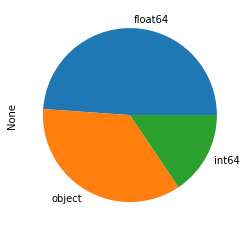

In [16]:
df.dtypes.value_counts().plot.pie()

In [17]:
# For fun, display the points on a map
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[df.loc[0, 'Latitude'], df.loc[0, 'Longitude']], zoom_start=13)
marker_cluster = MarkerCluster().add_to(m)

for index, row in df.iterrows():
	folium.Marker([row['Latitude'], row['Longitude']]).add_to(marker_cluster)

m

<AxesSubplot:>

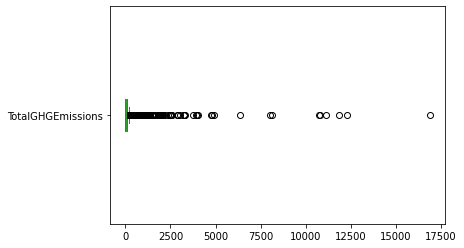

In [18]:
df.TotalGHGEmissions.plot(kind='box', vert= False)

In [19]:
def dropOutlierIQR(df, col):
    Q1 = df[col].quantile(0.25)
    # print(Q1)
    Q3 = df[col].quantile(0.75)
    # print(Q3)
    IQR = Q3 - Q1
    # print(IQR)
    df[col] = df[col][df[col].between((Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR))]

In [20]:
dropOutlierIQR(df, 'TotalGHGEmissions')

<AxesSubplot:>

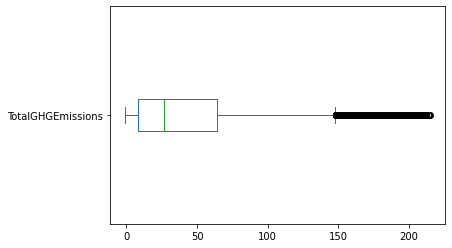

In [21]:
df.TotalGHGEmissions.plot(kind='box', vert= False)

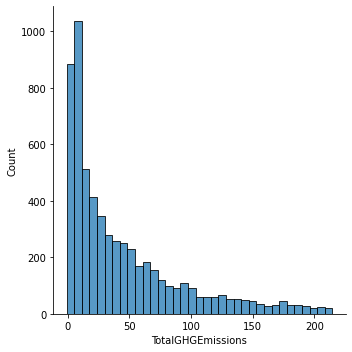

In [22]:
sns.displot(df.TotalGHGEmissions)

<AxesSubplot:>

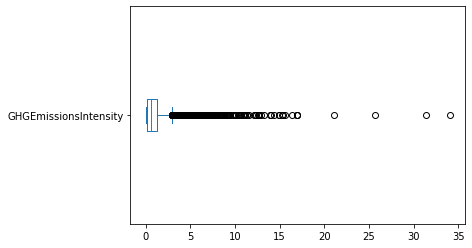

In [23]:
df.GHGEmissionsIntensity.plot(kind='box', vert= False)

In [24]:
dropOutlierIQR(df, 'GHGEmissionsIntensity')

<AxesSubplot:>

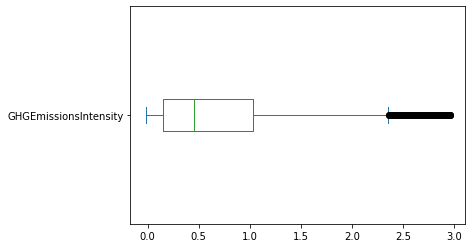

In [25]:
df.GHGEmissionsIntensity.plot(kind='box', vert= False)

<AxesSubplot:xlabel='GHGEmissionsIntensity', ylabel='Density'>

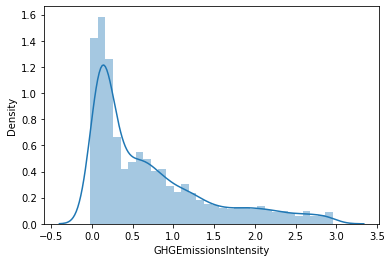

In [26]:
sns.distplot(df.GHGEmissionsIntensity)

<AxesSubplot:ylabel='Frequency'>

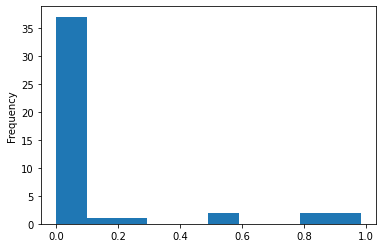

In [27]:
# show columns with (too much) empty values
df.isna().mean().sort_values().plot(kind="hist")

In [28]:
for col in df.columns:
	if df[col].isna().mean() > 0.5:
		print('removing empty column: ', col)
		df.drop(col, axis=1, inplace=True)


removing empty column:  SecondLargestPropertyUseType
removing empty column:  SecondLargestPropertyUseTypeGFA
removing empty column:  ThirdLargestPropertyUseType
removing empty column:  ThirdLargestPropertyUseTypeGFA
removing empty column:  YearsENERGYSTARCertified
removing empty column:  Outlier


<AxesSubplot:>

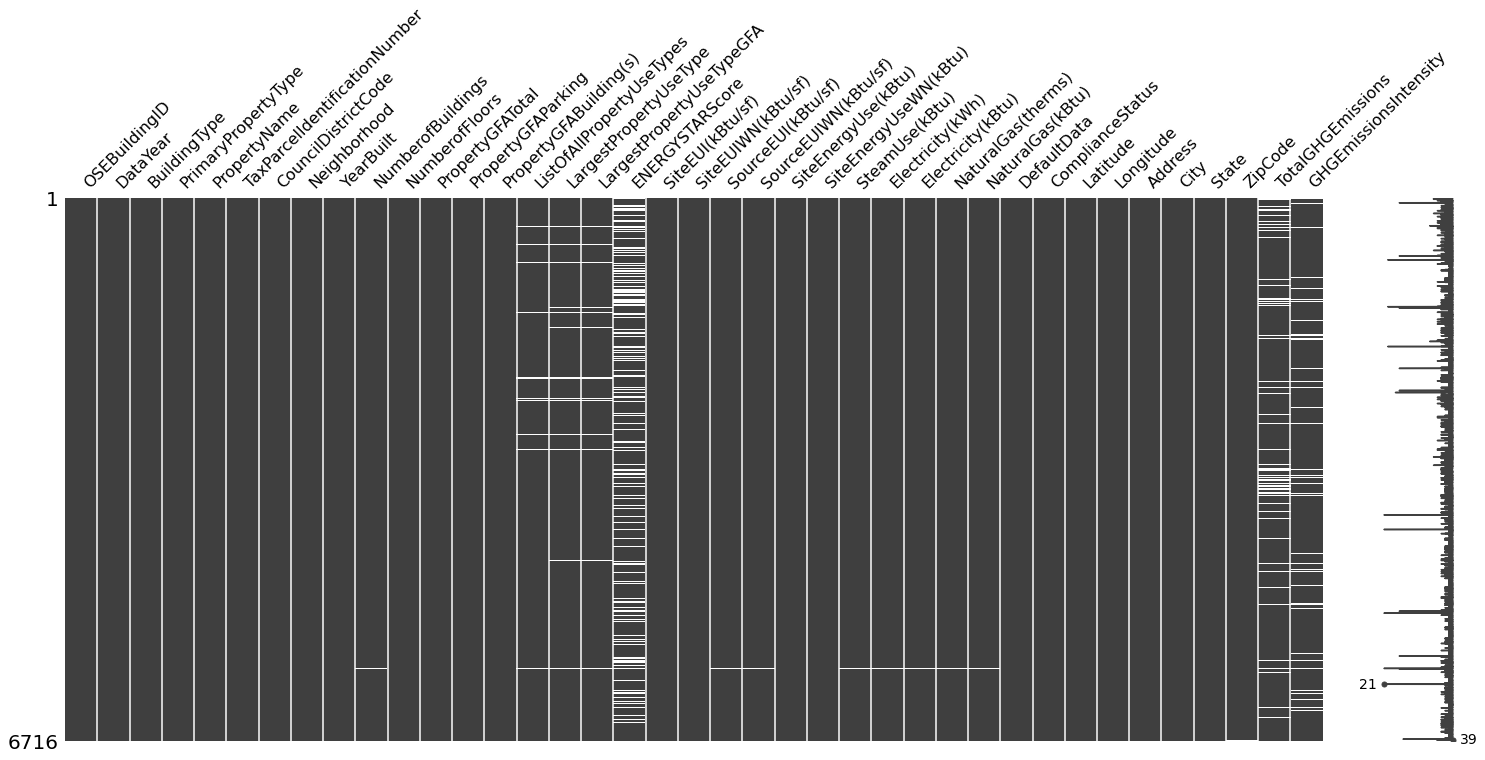

In [29]:
import missingno as msno
msno.matrix(df)

In [30]:
# features correlations
def show_feat_correlations(df):
	correlations = np.abs(df.select_dtypes('float').corr(method="pearson"))

	mask = np.zeros_like(correlations)
	mask[np.triu_indices_from(mask)] = True
	sns.axes_style("white")
	plt.subplots(figsize=(20,20))
	sns.heatmap(correlations, mask=mask, vmax=1, square=True, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True, cmap='cividis')

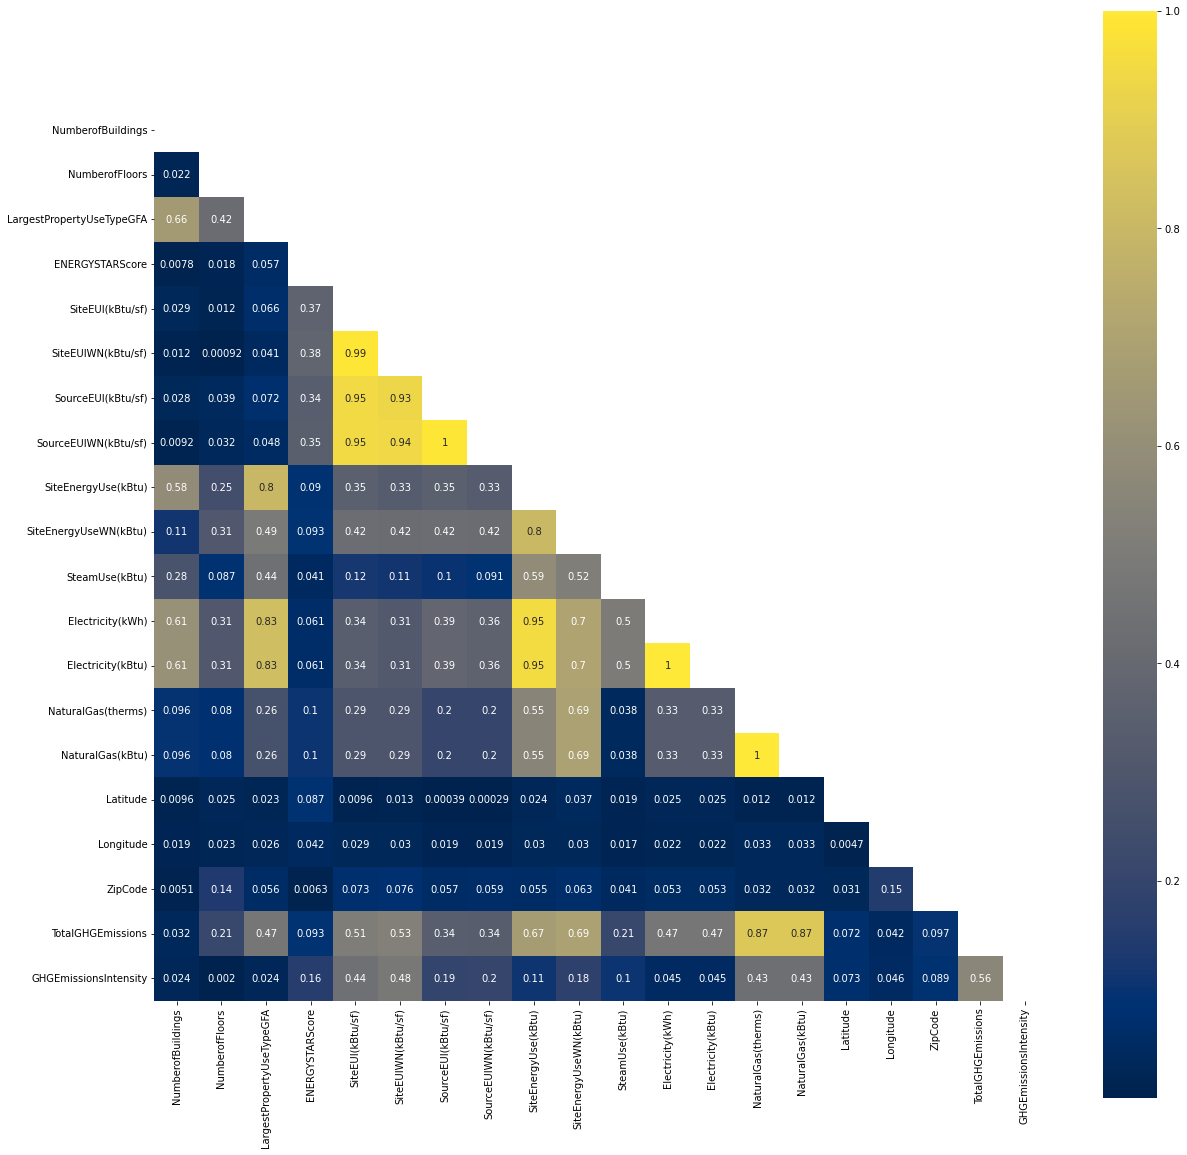

In [31]:
show_feat_correlations(df)

In [32]:
# don't need this feature, since duplicates the one with kBtu
df.drop('Electricity(kWh)', axis=1, inplace=True)

# also, we don't need the features 'WN', they are highly correlated with their siblings 'without WN'
colsWN = []
for col in df.columns:
	if 'WN' in col:
		colsWN.append(col)
df.drop(colsWN, axis=1, inplace=True)

# lastly, we can remove NaturalGas(therms), since it the same than naturalGas(kBtu), only the unit change
df.drop('NaturalGas(therms)', axis=1, inplace=True)

# State has unique value
df.drop('State', axis=1, inplace=True)

In [33]:
for col in df.columns:
	if df[col].isna().mean() > 0.5:
		df.drop(col, axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 6715
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  6716 non-null   int64  
 1   DataYear                       6716 non-null   int64  
 2   BuildingType                   6716 non-null   object 
 3   PrimaryPropertyType            6716 non-null   object 
 4   PropertyName                   6716 non-null   object 
 5   TaxParcelIdentificationNumber  6714 non-null   object 
 6   CouncilDistrictCode            6716 non-null   int64  
 7   Neighborhood                   6716 non-null   object 
 8   YearBuilt                      6716 non-null   int64  
 9   NumberofBuildings              6708 non-null   float64
 10  NumberofFloors                 6708 non-null   float64
 11  PropertyGFATotal               6716 non-null   int64  
 12  PropertyGFAParking             6716 non-null   i

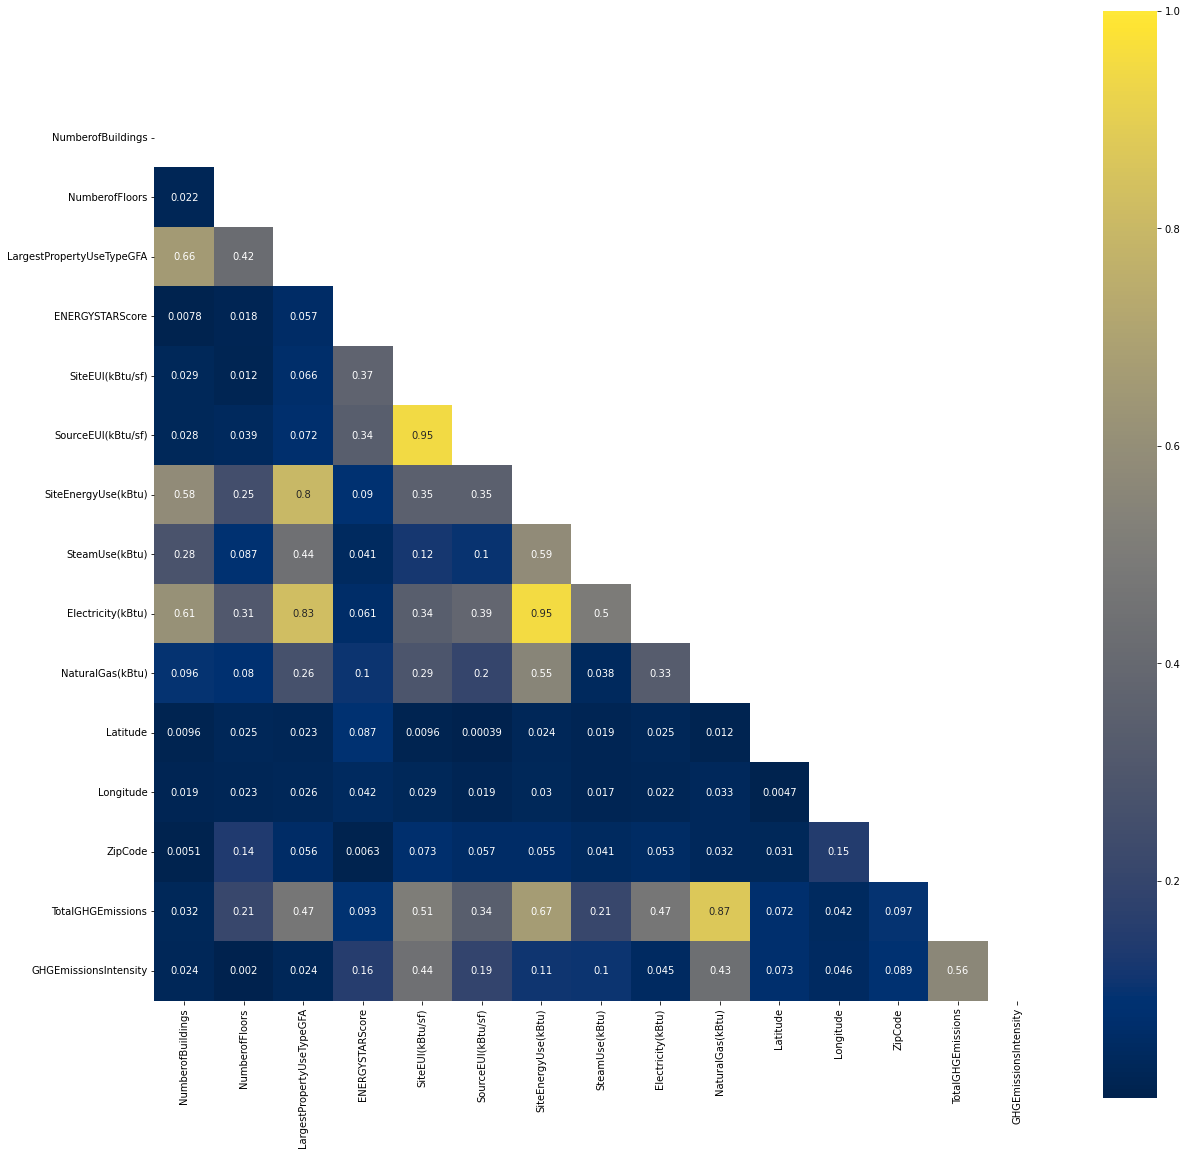

In [35]:
show_feat_correlations(df)

<AxesSubplot:ylabel='None'>

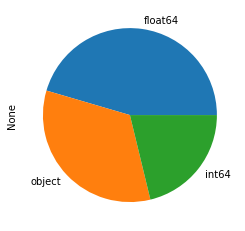

In [38]:
df.dtypes.value_counts().plot.pie()

In [36]:
df.select_dtypes('object')

,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,DefaultData,ComplianceStatus,Address,City
0,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,DOWNTOWN,Hotel,Hotel,No,Compliant,405 OLIVE WAY,SEATTLE
1,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,DOWNTOWN,"Hotel, Parking, Restaurant",Hotel,No,Compliant,724 PINE ST,SEATTLE
2,NonResidential,Hotel,WESTIN HOTEL,659000475,DOWNTOWN,"Hotel, Parking, Swimming Pool",Hotel,Yes,Compliant,1900 5TH AVE,SEATTLE
3,NonResidential,Hotel,HOTEL MAX,659000640,DOWNTOWN,Hotel,Hotel,No,Compliant,620 STEWART ST,SEATTLE
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,DOWNTOWN,"Hotel, Parking, Swimming Pool",Hotel,No,Compliant,401 LENORA ST,SEATTLE
...,...,...,...,...,...,...,...,...,...,...,...
6711,Nonresidential COS,Office,Horticulture building,1624049080,GREATER DUWAMISH,Office,Office,True,Error - Correct Default Data,1600 S Dakota St,Seattle
6712,Nonresidential COS,Other,International district/Chinatown CC,3558300000,DOWNTOWN,Other - Recreation,Other - Recreation,False,Compliant,719 8th Ave S,Seattle
6713,Nonresidential COS,Other,Queen Anne Pool,1794501150,MAGNOLIA / QUEEN ANNE,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,False,Compliant,1920 1st Ave W,Seattle
6714,Nonresidential COS,Mixed Use Property,South Park Community Center,7883603155,GREATER DUWAMISH,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,False,Compliant,8319 8th Ave S,Seattle


In [40]:
df.select_dtypes('object').nunique()

BuildingType                        8
PrimaryPropertyType                32
PropertyName                     6527
TaxParcelIdentificationNumber    3729
Neighborhood                       19
ListOfAllPropertyUseTypes         488
LargestPropertyUseType             57
DefaultData                         4
ComplianceStatus                    5
Address                          6379
City                                2
dtype: int64

count                     6716
unique                      32
top       Low-Rise Multifamily
freq                      1985
Name: PrimaryPropertyType, dtype: object


<AxesSubplot:>

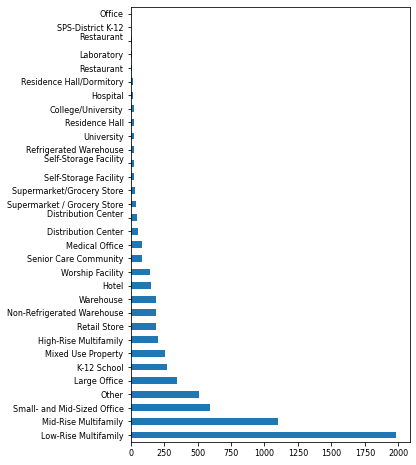

In [80]:
print(df.PrimaryPropertyType.describe())

plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(5,8))
df.PrimaryPropertyType.value_counts().plot(kind='barh')

In [94]:
print(df.ListOfAllPropertyUseTypes.describe())
df.ListOfAllPropertyUseTypes.head()
# this feature is a concatenation of several values, seperated by ', '

count                    6580
unique                    488
top       Multifamily Housing
freq                     1728
Name: ListOfAllPropertyUseTypes, dtype: object


0                            Hotel
1       Hotel, Parking, Restaurant
2    Hotel, Parking, Swimming Pool
3                            Hotel
4    Hotel, Parking, Swimming Pool
Name: ListOfAllPropertyUseTypes, dtype: object

In [99]:
df.ListOfAllPropertyUseTypes[50].split(', ')

['Hotel', 'Parking', 'Restaurant', 'Retail Store']

In [120]:
def split_words(col):
	unique_word = []
	for row in col.dropna():
		words = row.split(",")
		for w in words:
			if not w in unique_word:
				unique_word.append(w)
	return unique_word

In [121]:
split_words(df.ListOfAllPropertyUseTypes)

['Hotel',
 ' Parking',
 ' Restaurant',
 ' Swimming Pool',
 'Police Station',
 'Other - Entertainment/Public Assembly',
 'Multifamily Housing',
 'Data Center',
 ' Library',
 'Fitness Center/Health Club/Gym',
 ' Office',
 'Office',
 ' Other',
 ' Other - Lodging/Residential',
 ' Social/Meeting Hall',
 'Courthouse',
 'Other',
 'K-12 School',
 'College/University',
 'Automobile Dealership',
 ' Retail Store',
 ' Multifamily Housing',
 ' Other - Entertainment/Public Assembly',
 'Self-Storage Facility',
 'Non-Refrigerated Warehouse',
 ' Other - Education',
 ' Self-Storage Facility',
 ' Vocational School',
 'Parking',
 ' Senior Care Community',
 'Senior Care Community',
 'Medical Office',
 ' Medical Office',
 ' Non-Refrigerated Warehouse',
 'Retail Store',
 ' Distribution Center',
 'Hospital (General Medical & Surgical)',
 'Museum',
 'Repair Services (Vehicle',
 ' Shoe',
 ' Locksmith',
 ' etc)',
 'Food Service',
 'Residence Hall/Dormitory',
 ' Other - Services',
 'Restaurant',
 'Other/Specialty

<AxesSubplot:>

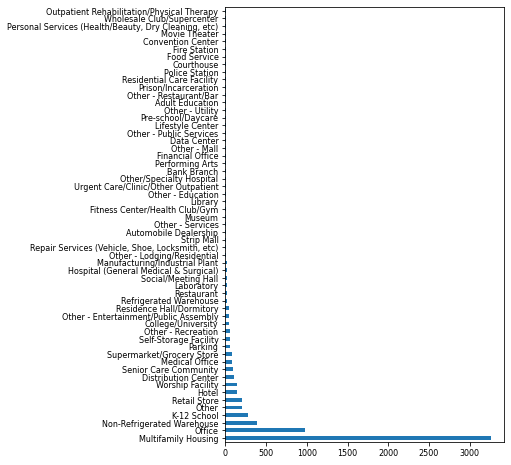

In [124]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(5,8))
df.LargestPropertyUseType.value_counts().plot(kind='barh')

<AxesSubplot:>

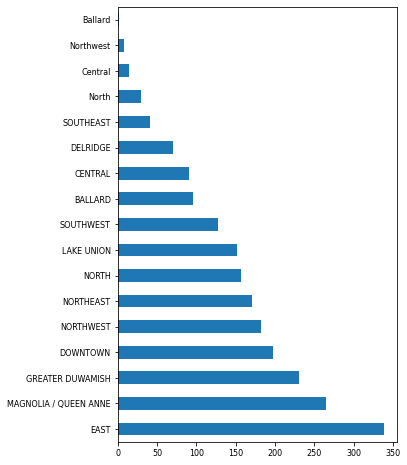

In [195]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(5,8))
df.Neighborhood.value_counts().plot(kind='barh')


<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Neighborhood'>

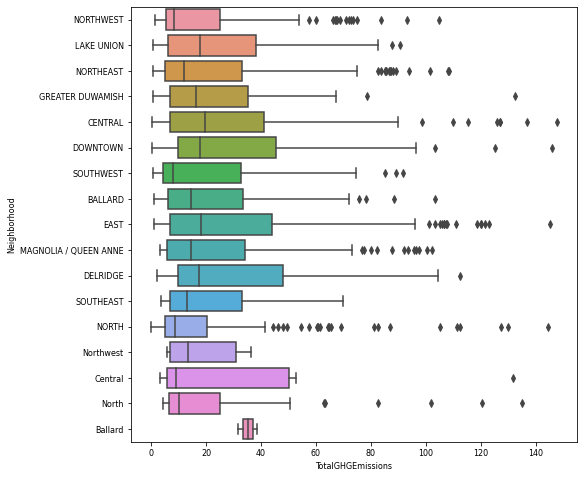

In [217]:
plt.figure(figsize=(8,8))
sns.boxplot(x='TotalGHGEmissions', y='Neighborhood', data=df)

<AxesSubplot:xlabel='BuildingAge', ylabel='TotalGHGEmissions'>

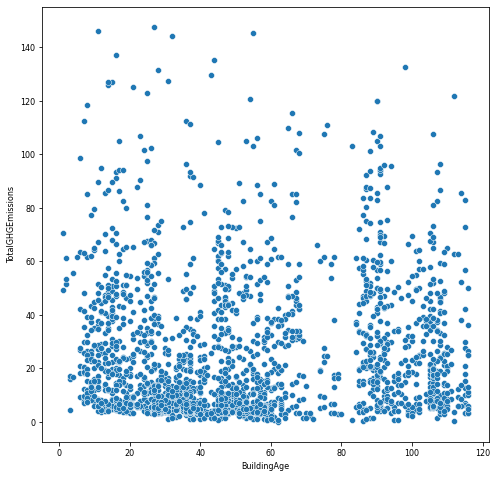

In [220]:
plt.figure(figsize=(8,8))
sns.scatterplot(y='TotalGHGEmissions', x='BuildingAge', data=df)

In [159]:
df.select_dtypes('float')

,OSEBuildingID,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Latitude,Longitude,ZipCode,TotalGHGEmissions,GHGEmissionsIntensity
0,NaN,1.0,NaN,88434.0,0.0,88434.0,88434.0,65.0,78.900000,173.500000,6.981428e+06,NaN,3.686160e+06,1.272388e+06,47.612190,-122.337997,98101.0,NaN,NaN
1,NaN,1.0,NaN,103566.0,NaN,88502.0,83880.0,51.0,94.400000,191.300000,8.354235e+06,0.0,3.905411e+06,NaN,47.613106,-122.333358,98101.0,NaN,NaN
2,NaN,1.0,NaN,NaN,0.0,NaN,NaN,18.0,96.600000,242.700000,NaN,NaN,NaN,NaN,47.613349,-122.337699,98101.0,NaN,1.92
3,NaN,1.0,NaN,61320.0,0.0,61320.0,61320.0,1.0,NaN,NaN,NaN,NaN,2.769023e+06,2.001894e+06,47.614216,-122.336609,98101.0,NaN,NaN
4,NaN,1.0,NaN,119890.0,NaN,107430.0,123445.0,67.0,NaN,228.800000,NaN,0.0,NaN,NaN,47.613754,-122.340924,98121.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,NaN,1.0,1.0,12294.0,0.0,12294.0,12294.0,46.0,69.099998,161.699997,8.497457e+05,0.0,5.242709e+05,3.254750e+05,47.567220,-122.311540,NaN,20.94,1.70
6712,NaN,1.0,1.0,16000.0,0.0,16000.0,16000.0,NaN,59.400002,114.199997,9.502762e+05,0.0,3.965461e+05,5.537300e+05,47.596250,-122.322830,NaN,32.17,2.01
6713,NaN,1.0,1.0,13157.0,0.0,13157.0,7583.0,NaN,NaN,NaN,5.765898e+06,0.0,1.792159e+06,NaN,47.636440,-122.357840,NaN,NaN,NaN
6714,NaN,1.0,1.0,14101.0,0.0,14101.0,6601.0,NaN,51.000000,105.300003,7.194712e+05,0.0,3.488702e+05,3.706010e+05,47.528320,-122.324310,NaN,22.11,1.57


In [154]:
for col in df.select_dtypes('float').columns:
	dropOutlierIQR(df, col)

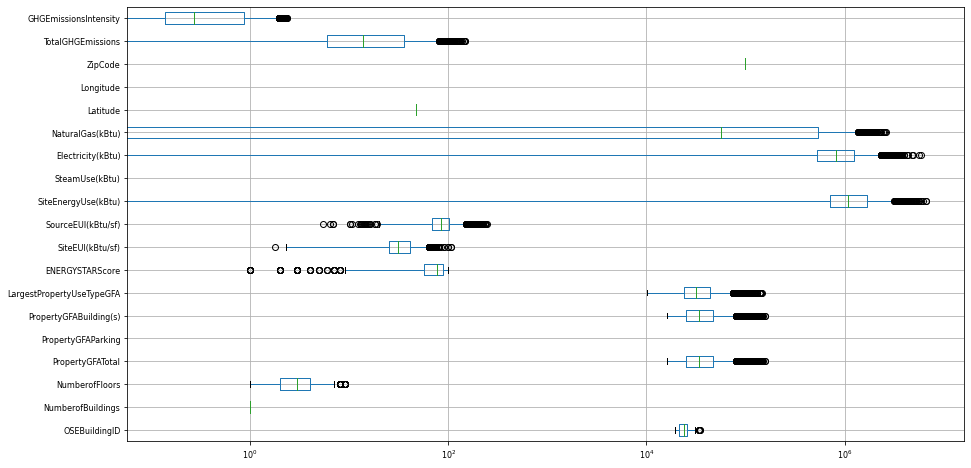

In [191]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(15,8))
df.select_dtypes('float').boxplot(vert=False)
plt.xscale('log')

# Zipcode feature is not interesting, we could drop it

In [189]:
df.dropna(inplace=True)

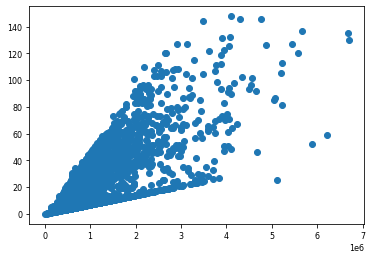

In [190]:
plt.scatter(df['SiteEnergyUse(kBtu)'], df.TotalGHGEmissions)

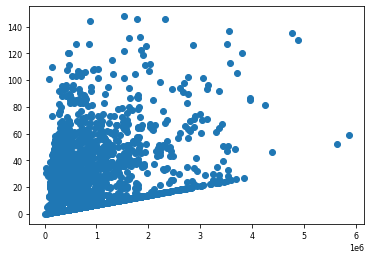

In [192]:
plt.scatter(df['Electricity(kBtu)'], df.TotalGHGEmissions)

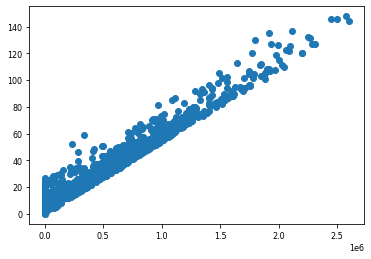

In [193]:
plt.scatter(df['NaturalGas(kBtu)'], df.TotalGHGEmissions)

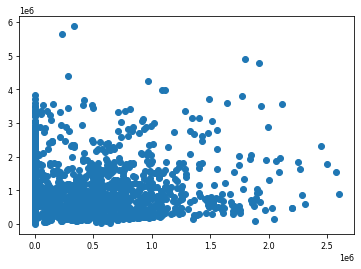

In [194]:
plt.scatter(df['NaturalGas(kBtu)'], df['Electricity(kBtu)'])

In [186]:
df['SteamUse(kBtu)'].describe()
# this feature can be removed

count    6437.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: SteamUse(kBtu), dtype: float64

In [158]:
df.select_dtypes('int')

,DataYear,CouncilDistrictCode,YearBuilt,BuildingAge
0,2015,7,1927,88
1,2015,7,1996,19
2,2015,7,1969,46
3,2015,7,1926,89
4,2015,7,1980,35
...,...,...,...,...
6711,2016,2,1990,26
6712,2016,2,2004,12
6713,2016,7,1974,42
6714,2016,1,1989,27


In [130]:
# feature engineering
df['BuildingAge'] = df.DataYear - df.YearBuilt

In [137]:
gfa_cols = [col for col in df.columns if 'GFA' in col]
gfa_cols
# these columns represent the space in square feet of gross floor area

['PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA']

In [156]:
for col in df.select_dtypes('int').columns:
	dropOutlierIQR(df, col)

<AxesSubplot:>

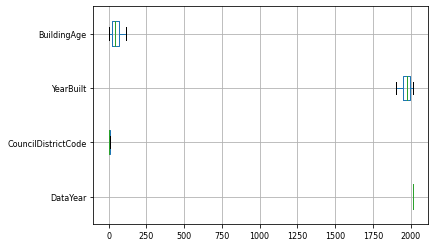

In [166]:
df.select_dtypes('int').boxplot(vert=False)
# plt.xscale('log')
# except BuildingAge, none of these features are very interesting, we could drop them


<AxesSubplot:>

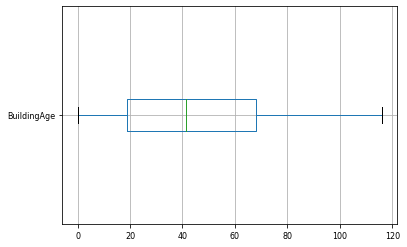

In [168]:
df.drop(['YearBuilt', 'CouncilDistrictCode', 'DataYear'], axis=1).select_dtypes('int').boxplot(vert=False)